In [1]:
%load_ext autoreload 
%autoreload 2 
import pandas as pd
import numpy as np
from scipy.stats import norm
from quantstats.stats import sharpe
import numpy as np
from numpy.core.numeric import normalize_axis_tuple
from numpy.core.overrides import array_function_dispatch, set_module
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

market_data = pd.read_parquet('data/US/test_mkt_data.pq')
earnings = pd.read_parquet('data/US/test_earnings.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_universe_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

In [14]:
%load_ext autoreload
%autoreload 2
from econometrics import *

market_features = pd.read_parquet('data/US/market_features.pq')
beta = market_features['beta_252'].unstack().reindex_like(P).ffill()
alpha = market_features['alpha_daily_returns'].unstack().reindex_like(P).ffill()
biannual_returns =market_features['biannual_returns'].unstack().reindex_like(P).ffill()
biannual_returns = biannual_returns.rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
ret = market_features['norm_annual_return'].unstack().reindex_like(P).ffill()
ret = ret.sub(ret.mean(1),0)
sigma = alpha.rolling(252).std()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

income_statement= pd.read_parquet('data/US/test_income_statement.pq')
income_statement['filing_date'] = pd.to_datetime(income_statement['filing_date'])
income_statement= income_statement.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
income_statement.index.names = ['Date','Ticker']



cash_flow= pd.read_parquet('data/US/test_cash_flow.pq')
cash_flow['filing_date'] = pd.to_datetime(cash_flow['filing_date'])
cash_flow= cash_flow.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
cash_flow.index.names = ['Date','Ticker']


balance_sheet= pd.read_parquet('data/US/test_balance_sheet.pq')
balance_sheet['filing_date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet= balance_sheet.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
balance_sheet.index.names = ['Date','Ticker']

In [5]:
income_statement= income_statement[~income_statement.index.duplicated(keep='last')]
balance_sheet= balance_sheet[~balance_sheet.index.duplicated(keep='last')]
cash_flow= cash_flow[~cash_flow.index.duplicated(keep='last')]

In [56]:
total_assets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)

In [6]:
sales = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
rd = income_statement['researchDevelopment'].unstack().reindex_like(P).ffill().astype(float)
depr = income_statement['depreciationAndAmortization'].unstack().reindex_like(P).ffill().astype(float)
cogs = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)
gross_profit = income_statement['grossProfit'].unstack().reindex_like(P).ffill().astype(float)
taxes = income_statement['incomeTaxExpense'].unstack().reindex_like(P).ffill().astype(float)
nopat =gross_profit - taxes
shares_out = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)

In [7]:
total_eq = balance_sheet['commonStockTotalEquity'].unstack().reindex_like(P).ffill().astype(float)
lt_debt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
pref_stock = balance_sheet['preferredStockTotalEquity'].unstack().reindex_like(P).ffill().astype(float)
minor = balance_sheet['temporaryEquityRedeemableNoncontrollingInterests'].unstack().reindex_like(P).ffill().astype(float)

invest_capital = total_eq + lt_debt + pref_stock + minor
invest_capital = invest_capital[invest_capital>0]
fcf = cash_flow['freeCashFlow'].unstack().reindex_like(P).ffill().astype(float)

In [8]:
roic = nopat / invest_capital
alpha = (fcf / total_eq).diff(252)
alpha = alpha.replace({-np.inf:np.nan, np.inf:np.nan})

def decile_rank(row):
    return pd.qcut(row.rank(method='first'), 10, labels=False,duplicates='drop')
def center(x):
    mean = x.mean(1)
    return x.sub(mean,0)
# alpha = alpha.dropna(axis=0,how = 'all').apply(decile_rank, axis=1)

sharpe       1.139589
turnover    21.337188
biais        0.871221
dtype: float64

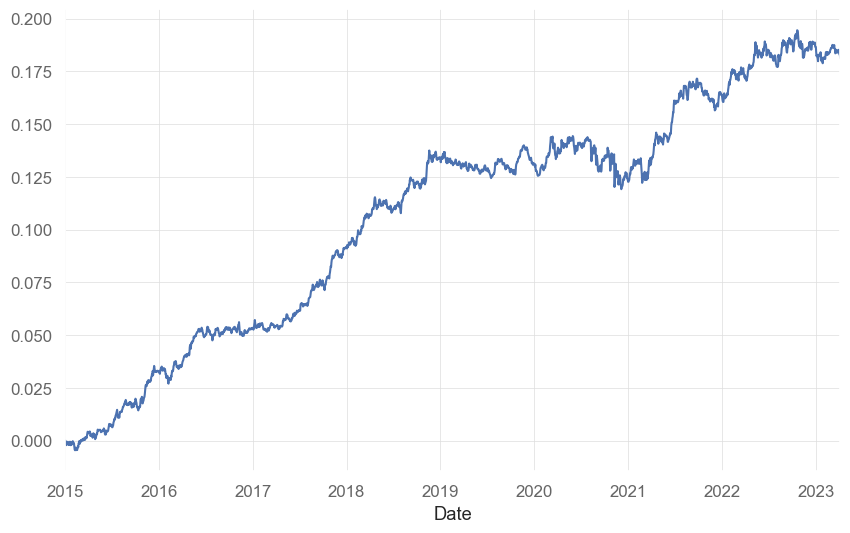

In [9]:
signal = alpha.ffill()[P].copy()
signal = signal[P].rank(axis=1,pct=True).clip(0.001,0.99).apply(norm.ppf)
signal = signal.groupby(GICS['sector'],axis=1).apply(center)
signal = signal[P].sub(signal.mean(1),0)
signal = signal[P].div(signal.abs().sum(1),0)
pnl = (signal[P].shift()*R.clip(-0.1,0.1)).loc['2015':].sum(1)
pnl.cumsum().plot()
pd.Series({"sharpe":sharpe(pnl),
           'turnover':signal.diff().abs().sum().mean()*100,
           'biais' : pnl[pnl!=0].mean()*1e4})

sharpe      -0.190407
turnover    79.356533
biais       -0.279342
dtype: float64

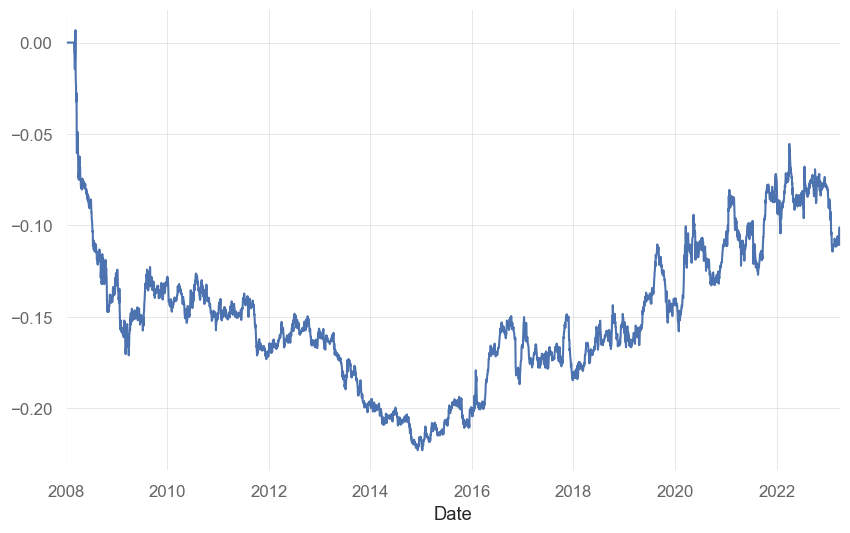

In [23]:
alpha = shares_out.pct_change(21)
signal = alpha.ffill()[P].copy()
signal = signal[P].rank(axis=1,pct=True).clip(0.001,0.99).apply(norm.ppf)
# signal = signal.groupby(GICS['sector'],axis=1).apply(center)
signal = signal[P].sub(signal.mean(1),0)
signal = signal[P].div(signal.abs().sum(1),0)
pnl = (signal[P].shift()*R.clip(-0.1,0.1)).sum(1)
pnl.cumsum().plot()
pd.Series({"sharpe":sharpe(pnl),
           'turnover':signal.diff().abs().sum().mean()*100,
           'biais' : pnl[pnl!=0].mean()*1e4})

sharpe      1.102316
turnover    4.716367
biais       0.993233
dtype: float64

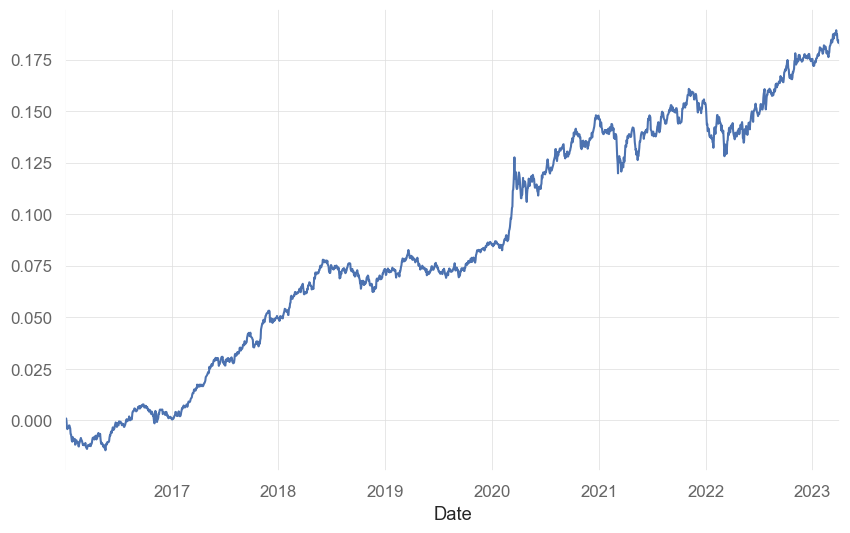

In [63]:
cash = balance_sheet['cash'].unstack().reindex_like(P).astype(float).ffill()
alpha = cash / total_assets
signal = alpha.ffill()[P].copy()
signal = signal[P].rank(axis=1,pct=True).clip(0.001,0.99).apply(norm.ppf).loc['2016':]
signal = signal.groupby(GICS['gicind'],axis=1).apply(center)
# signal = signal[P].sub(signal.mean(1),0)
signal = signal[P].div(signal.abs().sum(1),0)
pnl = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
pnl.cumsum().plot()
pd.Series({"sharpe":sharpe(pnl),
           'turnover':signal.diff().abs().sum().mean()*100,
           'biais' : pnl[pnl!=0].mean()*1e4})

In [2]:
from full_fred.fred import Fred
import datetime
import pandas as pd
def get_fred_serie(
    serie, period_start="1960-01-01", period_end=datetime.datetime.today()
):
    fred = Fred("key.text")
    df = fred.get_series_df(serie).replace(".", np.nan)
    df["value"] = df["value"].astype(float)
    df = df[["date", "value"]]
    df.rename(columns={"date": "datetime", "value": serie}, inplace=True)
    if len(df) > 0:
        df["datetime"] = pd.to_datetime(df["datetime"])

    df = df[df["datetime"] > period_start]
    df = df[df["datetime"] < period_end]
    return df.dropna()

get_fred_serie('TEDRATE')


FileNotFoundError: Can't find key.text on path